In [1]:
# ! pip install pandas --upgrade pip

In [2]:
# ! pip install pandas==1.5.3

In [1]:
import os 
import pandas as pd 
import numpy as np 
import re
import tqdm 
import matplotlib.pyplot as plt
import pickle

import nltk
from nltk import ngrams
import seaborn as sns

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
from collections import Counter
import sentencepiece as spm

In [3]:
print(pd.__version__)

1.5.3


In [4]:
directory = os.getenv('HOME') + '/aiffel/aiffelthon'

In [5]:
df_train = pd.read_csv(directory + '/train_data_0324.csv')
df_test = pd.read_csv(directory + '/test_data_0324.csv')
# df_test['weight'] = df_test['tok_cat'].apply(lambda x : 14 - x)
# df_test = df_test.loc[df_test['tok_cat'] < 6].sample(n=250, weights = 'weight' ,random_state=6) # validation 시간이 너무 오래 걸림, 250개만 사용

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948219 entries, 0 to 948218
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  948219 non-null  int64 
 1   reg         948219 non-null  object
 2   topic       948219 non-null  object
 3   stdn        948219 non-null  object
 4   dial        948219 non-null  object
 5   eng         948219 non-null  object
dtypes: int64(1), object(5)
memory usage: 43.4+ MB


In [7]:
df_train.head()

,Unnamed: 0,reg,topic,stdn,dial,eng
0,0,jd,역사,생각이 쪼금씩 바뀌더라고,생각이 쪼금씩 바뀌드라고,I've changed my mind a little bit.
1,1,jd,가족,어 알겠는가 외국인들이 그래도 잘 적응하고,어 알겄는가 애국인들이 그또 잘 적응하고,You know what? Foreigners still get used to it.
2,2,jd,건강,아으 갑자기 예전에 맹장 뜯은 게 생각난다.,아으 갑자기 에전에 맹장 뜯은 게 생각난디야.,"All of a sudden, I think I've ripped off my ap..."
3,3,jd,스타일,보면은 조금 품위 있게 나이 들어가야 되겠단 생각을 참 많이 해요.,보먼은 쫌 품위 있게 나이 들어가야 되겠단 싱각을 참 많이 해요잉.,I have a lot of ideas about getting older in a...
4,4,jd,먹거리,약간 조금 약간 맛이 쪼끔 거시기 하긴 한데 그래도,약간 쫌 약간 맛이 쪼끔 머시기 하긴 한디 그또,"It's a little bit of a tastey, but still."


In [53]:
df_train.duplicated(subset='stdn').sum()

8079

In [54]:
df_train.duplicated(subset='dial').sum()

744

In [55]:
df_train.duplicated(subset='eng').sum()

62201

In [57]:
df_train.drop_duplicates(subset="dial", inplace = True , ignore_index = True ) 

In [58]:
df_train.drop_duplicates(subset="stdn", inplace = True , ignore_index = True ) 

In [59]:
df_train.drop_duplicates(subset="eng", inplace = True , ignore_index = True ) 

In [64]:
df_train.duplicated().sum()

0

In [65]:
df_train.isnull().sum()

Unnamed: 0    0
reg           0
topic         0
stdn          0
dial          0
eng           0
dtype: int64

In [66]:
# check duplicates
print('train duplicated count :' ,df_train.duplicated(subset='dial').sum())
print('test duplicated count :' ,df_test.duplicated(subset='dial').sum())

train duplicated count : 0
test duplicated count : 0


In [67]:
# check for any overlaps in train and test
tr_dial = df_train.dial.values
ts_dial = df_test.dial.values
temp_ = np.concatenate([tr_dial, ts_dial], axis=0)
temp_ = print('overlap count : ',pd.DataFrame(temp_).duplicated().sum())

overlap count :  0


### import Tokenizer

In [8]:
data_path = os.getenv('HOME') +'/PocLab/Preprocessing'

spm_8000 = spm.SentencePieceProcessor()
spm_8000.Load(data_path + '/vocab_8000/spm_dec_spm8009.model')

msp_8000 = spm.SentencePieceProcessor()
msp_8000.Load(data_path + '/vocab_8000/spm_dec_msp8009.model')

custom_msp_8000 =  spm.SentencePieceProcessor()
custom_msp_8000.Load(data_path + '/vocab_8000/spm_dec_cmsp8009.model')


True

In [9]:
# 토크나이저 dict 만들기

tokenizers_8000 = {'spm' : spm_8000, 'msp' : msp_8000, 'custom_msp' : custom_msp_8000}

In [10]:
regs = ['kw','jj','cc','gs','jd']

100%|██████████| 174655/174655 [00:04<00:00, 35788.60it/s]
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: Runtime

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50504 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 45236 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 51328 missing from current font.
  font.set_text(s, 0,

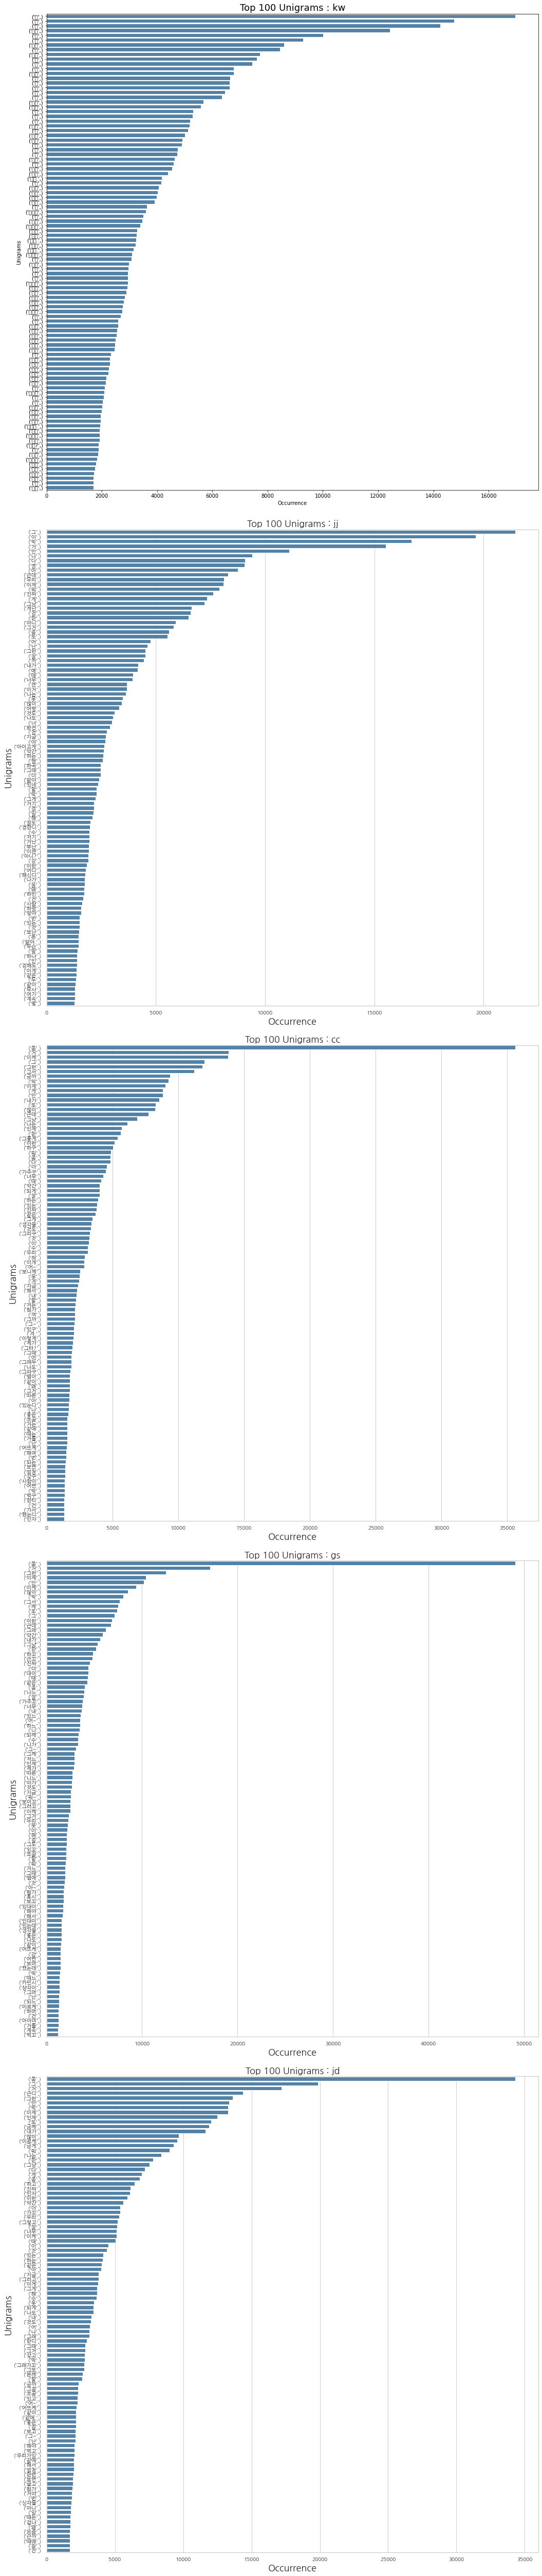

In [11]:
#by reg

fig = plt.figure(figsize=(15,70))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_8000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    df_pos = pd.DataFrame(frequency_pos.most_common(100))

    # Barplot that shows the top most common
    
    plt.subplot(5,1,i+1)
    sns.set(font_scale = 1.5, style = 'whitegrid', font ='NanumGothic')
    sns_pos_1 = sns.barplot(x = df_pos[1], y = df_pos[0], color = 'steelblue')

    # Setting axes labels
    sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Unigrams', title = f'Top 100 Unigrams : {reg}')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    
plt.tight_layout()
plt.show()

## tokenizer별 분산 확인 

In [12]:
dial = df_train.loc[df_train['reg'] == reg,'dial'].values
df_train['dial_r'] = df_train['dial'].apply(lambda x : re.sub('[?.,!]','',x))

In [73]:
import seaborn as sns
from nltk import ngrams
colors = ['r','g','darkviolet','orange','cyan']

def uni_bi_distribution_plot(tokenizer_dic, row, col):
    fig = plt.figure(figsize=(10,10))
    z = 0
    for i, tok in enumerate(tokenizer_dic.items()) :
        key, tokenizer = tok
        for n,reg in enumerate(regs) :
            # unigram
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                tokenized.extend(tok_encode)

            # Barplot that shows the top most common

            sns_pos_1 = plt.subplot(row,col,z+i+1)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

            # Setting axes labels
            sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Unigram Token Distribution by Region')
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend()

        # bigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,2)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)
        
        
        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Bigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1
            
        # Trigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,'dial_r'].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,3)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Trigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1

    plt.tight_layout()
    plt.show()

100%|██████████| 171056/171056 [00:07<00:00, 23462.28it/s]


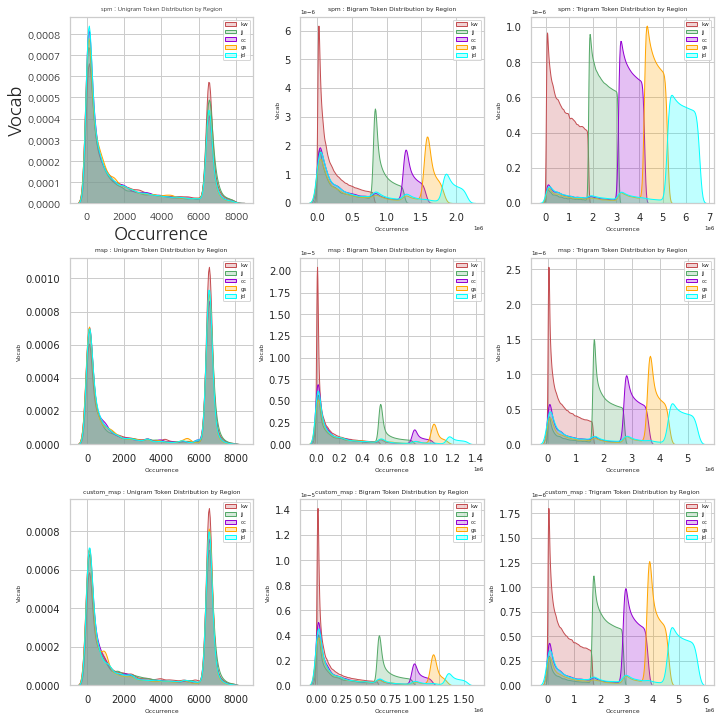

In [74]:
uni_bi_distribution_plot(tokenizers_8000, 3, 3)

In [13]:
from wordcloud import WordCloud
import matplotlib.font_manager

In [14]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
df_train['token'] = df_train['dial'].apply(mecab.morphs)

In [ ]:
plt.figure(figsize= (20,20))

for i, reg in enumerate(regs) :
    counter = Counter()
    for k in df_train.loc[df_train['reg'] == reg].token :
        counter.update(k)
    
    regs = counter.most_common(100)

    # font path http://corazzon.github.io/matplotlib_font_setting
    font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    font_list[0][1]
    wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=100 ,prefer_horizontal = 1)
    
    
    cloud = wc.generate_from_frequencies(counter)
    
    plt.subplot(3,2,i+1)
    plt.ylabel(reg)
    plt.imshow(cloud)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.suptitle('지역별 most-common 워드클라우드',  font ='NanumGothic')
plt.tight_layout()
plt.show()

In [26]:
for i, reg in enumerate(regs) :
    counter = Counter()
    for i in df_train['token'] :
        token_words = ngrams(i,2)
        counter.update(token_words)
    
        regs = counter.most_common(100)


        # font path http://corazzon.github.io/matplotlib_font_setting
        font_list = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
        font_list[0][1]
        wc = WordCloud(font_path= font_list[0][1], background_color='white',max_font_size=60)
    
    
        cloud = wc.generate_from_frequencies(dict(regs))
    
        plt.subplot(3,2,i+1)
        plt.ylabel(reg)
        plt.imshow(cloud)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

plt.suptitle('지역별 most-common 워드클라우드',  font ='NanumGothic')
plt.tight_layout()
plt.show()

TypeError: expected string

## 문제점 
- 강원데이터만 한글이 깨져서 나온다. 왜일까?
- wordcloud 잘 나오다가 갑자기 안나오네 ㅎㅎ 이런

In [14]:
plt.figure(figsize= (20,20))

for i, reg in enumerate(regs) :
    
    frequency_pos = Counter()
    dial = df_train.loc[df_train['reg'] == reg,'dial'].values
    for k in tqdm.tqdm(dial) :
        tokenized = ''.join(spm_8000.encode_as_pieces(k)).replace('▁',' ').split()
        token_words = ngrams(tokenized,1)
        frequency_pos.update(token_words)

    tags =frequency_pos.most_common(50)
    
    
#     wc = WordCloud(font_path= 'NanumGothic', background_color='white',max_font_size=60


    wc = WordCloud(
    font_path ="NanumGothic", # 폰트 지정
    width = 400, # 워드 클라우드의 너비 지정
    height =400, # 워드클라우드의 높이 지정
    max_font_size=100, # 가장 빈도수가 높은 단어의 폰트 사이즈 지정
    background_color="white"# 배경색 지정
    )
    
    cloud = wc.generate_from_frequencies(tags)
    
    
    
#     wordCloud = wordCloud.generate_from_frequencies(dict(wc))

100%|██████████| 344335/344335 [00:07<00:00, 45162.48it/s]


AttributeError: 'list' object has no attribute 'items'

<Figure size 1440x1440 with 0 Axes>